In [ ]:
# !pip install shapely

#%% Imports and utilities
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.animation as animation
from shapely.geometry import Point, Polygon

####################################################
# 1. PDE solver on the square (kept for reference)
####################################################
def solve_pde_2d_a(Nx=21, Ny=21, T=1.0, a=1.0, dt=0.0005):
    """
    Solve PDE: s_t = 0.5*( s_xx + a*s_yy ) on the square [0,1]^2,
    with boundary=1 and interior=0 at t=0.
    """
    x_vals = np.linspace(0,1,Nx)
    y_vals = np.linspace(0,1,Ny)
    dx = 1./(Nx-1)
    dy = 1./(Ny-1)
    n_steps= int(T/dt)+1
    t_vals= np.linspace(0,T,n_steps, dtype=np.float32)
    S_data= np.zeros((n_steps, Ny, Nx), dtype=np.float32)
    S_data[0, 0, :] = 1.0
    S_data[0, -1,:] = 1.0
    S_data[0, :, 0] = 1.0
    S_data[0, :,-1] = 1.0

    for k in range(n_steps-1):
        s_old= S_data[k]
        s_next= s_old.copy()
        for j in range(1,Ny-1):
            for i in range(1,Nx-1):
                s_xx= (s_old[j,i+1]-2*s_old[j,i] + s_old[j,i-1])/(dx*dx)
                s_yy= (s_old[j+1,i]-2*s_old[j,i] + s_old[j-1,i])/(dy*dy)
                dsdt= 0.5*( s_xx + a*s_yy )
                s_next[j,i]= s_old[j,i]+ dt* dsdt
        s_next[0,:]  =1.0
        s_next[-1,:] =1.0
        s_next[:,0]  =1.0
        s_next[:,-1] =1.0
        S_data[k+1]= s_next
    return x_vals, y_vals, t_vals, S_data

####################################################
# 2. New: PDE solver on the trapezoid using a mapped grid
####################################################
def solve_pde_trapezoid_mapped_grid(Nx=21, Ny=21, T=1.0, dt=0.001, a=1.0):
    """
    Solve PDE: s_t = 0.5*( s_xx + a*s_yy ) on a trapezoid whose geometry is defined
    by the mapping from the square [0,1]^2 to the trapezoid:
        X = -1.0 + 0.5*y + x*(2.0 - y)
        Y = y
    Here the PDE is solved directly on the mesh grid obtained by applying the above
    mapping to an equispaced square grid. This ensures that the (i,j) index grid is regular,
    so that it can be used directly for training the B-spline net.

    The spatial finite differences use variable spacing along the x-direction: for each row,
    the spacing dx depends on y (dx = (2 - y_j)/(Nx-1)), while dy is uniform (dy = 1/(Ny-1)).

    Boundary conditions: s = 1 on the boundary (which corresponds to the boundary of the trapezoid),
    and s = 0 in the interior at t=0.
    """
    # Create a regular square grid in parameter space
    x_sq = np.linspace(0, 1, Nx)
    y_sq = np.linspace(0, 1, Ny)
    X_sq, Y_sq = np.meshgrid(x_sq, y_sq, indexing='xy')

    # Map the square grid to the trapezoid using the given transformation
    # For each (x,y) in [0,1]^2, the trapezoid coordinates are:
    #   X = -1.0 + 0.5*y + x*(2.0 - y)
    #   Y = y
    X = -1.0 + 0.5 * Y_sq + X_sq * (2.0 - Y_sq)
    Y = Y_sq.copy()  # Y remains the same

    # Compute variable spacing in x: for each row j, dx = (2 - y_j)/(Nx-1)
    dx_arr = (2.0 - y_sq) / (Nx - 1)  # 1D array of length Ny
    dy = 1.0 / (Ny - 1)  # uniform spacing in y

    # Initialize solution: interior 0, boundary=1
    s = np.zeros((Ny, Nx), dtype=np.float32)
    s[0, :] = 1.0
    s[-1, :] = 1.0
    s[:, 0] = 1.0
    s[:, -1] = 1.0

    n_steps = int(T/dt) + 1
    t_vals = np.linspace(0, T, n_steps, dtype=np.float32)
    S_all = np.zeros((n_steps, Ny, Nx), dtype=np.float32)
    S_all[0] = s.copy()

    # Time-stepping loop using explicit Euler
    for step in range(1, n_steps):
        s_old = s.copy()
        # Loop over interior points only
        for j in range(1, Ny-1):
            dx = dx_arr[j]  # local spacing in x for row j
            for i in range(1, Nx-1):
                # Second derivative in x using nonuniform spacing for this row
                s_xx = (s_old[j, i+1] - 2*s_old[j, i] + s_old[j, i-1]) / (dx**2)
                # Second derivative in y with constant spacing
                s_yy = (s_old[j+1, i] - 2*s_old[j, i] + s_old[j-1, i]) / (dy**2)
                dsdt = 0.5 * (s_xx + a * s_yy)
                s[j, i] = s_old[j, i] + dt * dsdt
        # Re-impose boundary conditions
        s[0, :] = 1.0
        s[-1, :] = 1.0
        s[:, 0] = 1.0
        s[:, -1] = 1.0
        S_all[step] = s.copy()

    # Return the physical trapezoid grid (X, Y), time values, and solution S_all
    return X, Y, t_vals, S_all

####################################################
# 3. B-spline basis functions and basis building
####################################################
def BsFun(i, d, t, knots):
    if d==0:
        return 1.0 if knots[i-1] <= t < knots[i] else 0.0
    denomA = knots[d+i-1] - knots[i-1]
    denomB = knots[d+i] - knots[i]
    a_val = 0 if denomA == 0 else (t - knots[i-1]) / denomA
    b_val = 0 if denomB == 0 else (knots[d+i] - t) / denomB
    return a_val * BsFun(i, d-1, t, knots) + b_val * BsFun(i+1, d-1, t, knots)

def build_bspline_basis(n_cp, d, Nparam):
    n_knots = n_cp + d + 1
    knots = np.zeros(n_knots)
    for i in range(d+1, n_knots - d - 1):
        knots[i] = i - d
    knots[n_knots-d-1:] = n_cp - d
    param_vals = np.zeros(Nparam, dtype=np.float32)
    total_len = knots[-1] - knots[d]
    step = total_len / (Nparam - 1)
    for i in range(1, Nparam):
        param_vals[i] = param_vals[i-1] + step

    basis = np.zeros((Nparam, n_cp), dtype=np.float32)
    for j in range(n_cp):
        for i in range(Nparam):
            basis[i, j] = BsFun(j+1, d, param_vals[i], knots)
    basis[-1, -1] = 1.0
    return torch.tensor(basis, dtype=torch.float32), knots, param_vals

def build_bspline_derivatives(n_cp, d, Nparam, knots, param_vals):
    def BsFun_derivative(i, d, t):
        if d == 0:
            return 0.0
        denomA = knots[d+i-1] - knots[i-1]
        denomB = knots[d+i] - knots[i]
        A = 0 if denomA == 0 else d / denomA
        B = 0 if denomB == 0 else d / denomB
        return A * BsFun(i, d-1, t, knots) - B * BsFun(i+1, d-1, t, knots)

    def BsFun_second(i, d, t):
        if d < 2:
            return 0.0
        a_val = 0 if (knots[d+i-2] - knots[i-2]) == 0 else d*(d-1)/((knots[d+i-2]-knots[i-2])**2)
        b_val = 0 if (knots[d+i-1] - knots[i-1]) == 0 else 2*d*(d-1)/((knots[d+i-1]-knots[i-1])**2)
        c_val = 0 if (knots[d+i] - knots[i]) == 0 else d*(d-1)/((knots[d+i]-knots[i])**2)
        return a_val * BsFun(i, d-2, t, knots) - b_val * BsFun(i+1, d-2, t, knots) + c_val * BsFun(i+2, d-2, t, knots)

    deriv = np.zeros((Nparam, n_cp), dtype=np.float32)
    second = np.zeros((Nparam, n_cp), dtype=np.float32)
    for j in range(n_cp):
        for i in range(Nparam):
            t_val = param_vals[i]
            deriv[i, j] = BsFun_derivative(j+1, d, t_val)
            second[i, j] = BsFun_second(j+1, d, t_val)
    return torch.tensor(deriv, dtype=torch.float32), torch.tensor(second, dtype=torch.float32)

####################################################
# 4. B-spline net: input parameter "a" --> control points
####################################################
class BSplineNet_a(nn.Module):
    def __init__(self, n_cp_t, n_cp_x, n_cp_y, hidden_dim=64):
        super().__init__()
        self.n_cp_t = n_cp_t
        self.n_cp_x = n_cp_x
        self.n_cp_y = n_cp_y
        self.mlp = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_cp_t * n_cp_x * n_cp_y)
        )
    def forward(self, a_tensor):
        out = self.mlp(a_tensor)  # shape (b, n_cp_t*n_cp_x*n_cp_y)
        out = out.view(-1, self.n_cp_t, self.n_cp_x, self.n_cp_y)
        return out

####################################################
# 5. Loss: Combined data and PDE residual (with boundary/IC enforced)
####################################################
def compute_loss_pde_data_icbc(net, a_tensor, S_ref,
                               Bit_t, Bit_x, Bit_y,
                               Bit_t_deriv, Bit_x_second, Bit_y_second,
                               lambda_data=1.0, lambda_phys=1.0):
    b = a_tensor.shape[0]
    U_cp = net(a_tensor)  # shape (b, n_cp_t, n_cp_x, n_cp_y)

    # Enforce boundary conditions: at t=0 and spatial boundaries, set s=1
    U_mod = U_cp.clone()
    U_mod[:, 0, :, :] = 0.0
    U_mod[:, 0, 0 , :] = 1.0
    U_mod[:, 0, -1, :] = 1.0
    U_mod[:, 0, : , 0] = 1.0
    U_mod[:, 0, : ,-1] = 1.0
    U_mod[:,:, 0 , :] = 1.0
    U_mod[:,:,-1 , :] = 1.0
    U_mod[:,:,:,  0] = 1.0
    U_mod[:,:,:,-1] = 1.0

    S_pred = torch.einsum('btij,Tt,Xi,Yj->bTYX', U_mod, Bit_t, Bit_x, Bit_y)
    S_ref_4d = S_ref.unsqueeze(0).expand(b, -1, -1, -1)
    loss_data = (S_pred - S_ref_4d).pow(2).mean()

    S_t = torch.einsum('btij,Tt,Xi,Yj->bTYX', U_mod, Bit_t_deriv, Bit_x, Bit_y)
    S_xx = torch.einsum('btij,Tt,Xi,Yj->bTYX', U_mod, Bit_t, Bit_x_second, Bit_y)
    S_yy = torch.einsum('btij,Tt,Xi,Yj->bTYX', U_mod, Bit_t, Bit_x, Bit_y_second)

    a_broad = a_tensor.view(b,1,1,1)
    PDE_res = S_t - 0.5*(S_xx + a_broad*S_yy)
    loss_phys = PDE_res.pow(2).mean()

    total_loss = lambda_data * loss_data + lambda_phys * loss_phys
    return total_loss, loss_data, loss_phys, S_pred, U_mod

####################################################
# 6. (Optional) Mapping from square to trapezoid for visualization
####################################################
def map_square_to_trapezoid(S_sqr, Nx_sqr, Ny_sqr,
                            t_sqr, dt_sqr,
                            dx_trap, dt_trap,
                            T=1.0):
    """
    Map a solution defined on a square grid (S_sqr) to the trapezoid using the
    inverse of the mapping: X = -1+0.5*y + x*(2-y), Y = y.
    """
    vertices = [(-1,0), (1,0), (0.5,1.0), (-0.5,1.0)]
    poly = Polygon(vertices)
    arr = np.array(vertices)
    x_min, x_max = arr[:,0].min(), arr[:,0].max()
    y_min, y_max = arr[:,1].min(), arr[:,1].max()

    xs = np.arange(x_min, x_max+dx_trap, dx_trap)
    ys = np.arange(y_min, y_max+dx_trap, dx_trap)
    nx_t = len(xs)
    ny_t = len(ys)
    Xc, Yc = np.meshgrid(xs, ys, indexing='xy')

    in_mask = np.zeros((ny_t, nx_t), dtype=bool)
    for jj in range(ny_t):
        for ii in range(nx_t):
            if poly.covers(Point(xs[ii], ys[jj])):
                in_mask[jj,ii] = True

    nt_sqr = S_sqr.shape[0]
    nt_trap = int(T/dt_trap) + 1
    t_vals_trap = np.linspace(0, T, nt_trap)
    S_map = np.zeros((nt_trap, ny_t, nx_t))
    for k in range(nt_trap):
        t_req = t_vals_trap[k]
        idx_sqr = int(round(t_req/dt_sqr))
        idx_sqr = max(0, min(nt_sqr-1, idx_sqr))
        sqr_slice = S_sqr[idx_sqr]
        for j in range(ny_t):
            for i in range(nx_t):
                if in_mask[j,i]:
                    Xij = Xc[j,i]
                    Yij = Yc[j,i]
                    # Inverse mapping: from trapezoid to square
                    x_left = -1.0 + 0.5*Yij
                    x_right = 1.0 - 0.5*Yij
                    denom = x_right - x_left
                    if abs(denom) < 1e-12:
                        S_map[k,j,i] = 0.0
                    else:
                        x_in = (Xij - x_left) / denom
                        y_in = Yij
                        if x_in < 0 or x_in > 1 or y_in < 0 or y_in > 1:
                            S_map[k,j,i] = 0.0
                        else:
                            i_sqr = int(round(x_in*(Nx_sqr-1)))
                            j_sqr = int(round(y_in*(Ny_sqr-1)))
                            i_sqr = max(0, min(Nx_sqr-1, i_sqr))
                            j_sqr = max(0, min(Ny_sqr-1, j_sqr))
                            S_map[k,j,i] = sqr_slice[j_sqr, i_sqr]
                else:
                    S_map[k,j,i] = np.nan
    return S_map, Xc, Yc, in_mask

####################################################
# 7. Main script: Train the B-spline net using PDE data from the trapezoid solver on a mapped grid
####################################################
if __name__=="__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    ######## TRAINING DATA FROM PDE-TRAPEZOID (mapped grid) ########
    N_train = 20  # Increase this number for more training samples
    Nx = 21; Ny = 21; T = 1.0
    dt_trap = 0.001
    # Note: sample 'a' in [0, 1.5] for stability
    PDE_data = []
    for _ in range(N_train):
        a_i = float(np.random.uniform(0, 1.5))
        # Use the new trapezoid solver which computes the solution on a grid that
        # corresponds to a regular square (via the mapping)
        X_trap, Y_trap, t_trap, S_trap = solve_pde_trapezoid_mapped_grid(Nx, Ny, T, dt_trap, a=a_i)
        # S_trap is defined on a grid that corresponds (indexwise) to the square grid
        PDE_data.append((a_i, t_trap, S_trap))
    n_steps = PDE_data[0][2].shape[0]
    print("n_steps =>", n_steps)

    PDE_data_torch = []
    for (a_i, t_vals, sdat) in PDE_data:
        PDE_data_torch.append((
            torch.tensor([[a_i]], dtype=torch.float32, device=device),
            torch.tensor(sdat, dtype=torch.float32, device=device)
        ))

    # Use B-spline control points defined on the full spatio-temporal grid
    d = 3
    n_cp_t = n_steps; n_cp_x = Nx; n_cp_y = Ny

    def build_bases(n_cp, d, Nparam):
        basis, knots, param_vals = build_bspline_basis(n_cp, d, Nparam)
        derv, d2 = build_bspline_derivatives(n_cp, d, Nparam, knots, param_vals)
        return basis.to(device), derv.to(device), d2.to(device)

    Bit_t, Bit_t_deriv, Bit_t_second = build_bases(n_cp_t, d, n_steps)
    Bit_x, Bit_x_deriv, Bit_x_second = build_bases(n_cp_x, d, Nx)
    Bit_y, Bit_y_deriv, Bit_y_second = build_bases(n_cp_y, d, Ny)

    net = BSplineNet_a(n_cp_t, n_cp_x, n_cp_y, hidden_dim=64).to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)

    n_epochs = 3000  # Adjust epochs as needed
    def train_one_epoch():
        total_loss = 0.0
        for (a_i_torch, S_torch) in PDE_data_torch:
            loss, l_data, l_phys, S_pred, U_mod = compute_loss_pde_data_icbc(
                net, a_i_torch, S_torch,
                Bit_t, Bit_x, Bit_y,
                Bit_t_deriv, Bit_x_second, Bit_y_second,
                lambda_data=1.0,
                lambda_phys=1e-5
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(PDE_data_torch)

    print("Starting training...")
    for epoch in tqdm(range(n_epochs), desc="Training B-spline net"):
        avg_loss = train_one_epoch()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss= {avg_loss:.4e}")


Using device: cuda
n_steps => 1001
Starting training...


Training B-spline net:   0%|          | 1/3000 [00:01<53:22,  1.07s/it]

Epoch 0, loss= 4.4282e-01


Training B-spline net:   3%|▎         | 101/3000 [00:32<15:01,  3.22it/s]

Epoch 100, loss= 5.9874e-05


Training B-spline net:   7%|▋         | 201/3000 [01:03<14:27,  3.23it/s]

Epoch 200, loss= 3.2181e-05


Training B-spline net:  10%|█         | 301/3000 [01:34<13:57,  3.22it/s]

Epoch 300, loss= 4.2159e-05


Training B-spline net:  13%|█▎        | 401/3000 [02:05<13:24,  3.23it/s]

Epoch 400, loss= 2.1643e-05


Training B-spline net:  17%|█▋        | 501/3000 [02:36<12:55,  3.22it/s]

Epoch 500, loss= 4.9740e-05


Training B-spline net:  20%|██        | 601/3000 [03:07<12:26,  3.21it/s]

Epoch 600, loss= 1.3270e-05


Training B-spline net:  23%|██▎       | 701/3000 [03:38<11:56,  3.21it/s]

Epoch 700, loss= 2.5465e-05


Training B-spline net:  27%|██▋       | 801/3000 [04:09<11:24,  3.21it/s]

Epoch 800, loss= 4.5843e-05


Training B-spline net:  30%|███       | 901/3000 [04:40<10:50,  3.23it/s]

Epoch 900, loss= 2.2630e-05


Training B-spline net:  33%|███▎      | 1001/3000 [05:12<10:28,  3.18it/s]

Epoch 1000, loss= 2.3374e-05


Training B-spline net:  37%|███▋      | 1101/3000 [05:43<09:49,  3.22it/s]

Epoch 1100, loss= 3.6583e-05


Training B-spline net:  40%|████      | 1201/3000 [06:14<09:20,  3.21it/s]

Epoch 1200, loss= 1.6621e-05


Training B-spline net:  43%|████▎     | 1301/3000 [06:45<08:48,  3.21it/s]

Epoch 1300, loss= 1.8795e-05


Training B-spline net:  47%|████▋     | 1401/3000 [07:16<08:16,  3.22it/s]

Epoch 1400, loss= 2.8070e-05


Training B-spline net:  50%|█████     | 1501/3000 [07:47<07:46,  3.21it/s]

Epoch 1500, loss= 1.6393e-05


Training B-spline net:  53%|█████▎    | 1601/3000 [08:18<07:15,  3.21it/s]

Epoch 1600, loss= 1.9071e-05


Training B-spline net:  57%|█████▋    | 1701/3000 [08:49<06:47,  3.19it/s]

Epoch 1700, loss= 1.8851e-05


Training B-spline net:  60%|██████    | 1801/3000 [09:21<06:13,  3.21it/s]

Epoch 1800, loss= 1.6605e-05


Training B-spline net:  63%|██████▎   | 1901/3000 [09:52<05:41,  3.22it/s]

Epoch 1900, loss= 1.4750e-05


Training B-spline net:  67%|██████▋   | 2001/3000 [10:23<05:12,  3.19it/s]

Epoch 2000, loss= 5.7155e-05


Training B-spline net:  70%|███████   | 2101/3000 [10:54<04:38,  3.22it/s]

Epoch 2100, loss= 8.1040e-06


Training B-spline net:  73%|███████▎  | 2201/3000 [11:25<04:08,  3.21it/s]

Epoch 2200, loss= 1.2737e-05


Training B-spline net:  77%|███████▋  | 2301/3000 [11:56<03:37,  3.21it/s]

Epoch 2300, loss= 1.3338e-05


Training B-spline net:  80%|████████  | 2401/3000 [12:27<03:05,  3.23it/s]

Epoch 2400, loss= 1.2864e-05


Training B-spline net:  83%|████████▎ | 2501/3000 [12:58<02:35,  3.22it/s]

Epoch 2500, loss= 1.4802e-05


Training B-spline net:  87%|████████▋ | 2601/3000 [13:30<02:04,  3.21it/s]

Epoch 2600, loss= 2.3910e-05


Training B-spline net:  90%|█████████ | 2701/3000 [14:01<01:33,  3.20it/s]

Epoch 2700, loss= 8.1621e-06


Training B-spline net:  93%|█████████▎| 2801/3000 [14:32<01:02,  3.19it/s]

Epoch 2800, loss= 1.3482e-05


Training B-spline net:  97%|█████████▋| 2901/3000 [15:03<00:30,  3.23it/s]

Epoch 2900, loss= 1.0414e-05


Training B-spline net: 100%|██████████| 3000/3000 [15:34<00:00,  3.21it/s]


Plots

In [ ]:
######### TEST ON NEW a_test (using trapezoid solver on mapped grid) #########
a_test = float(np.random.uniform(0, 1.5))
# a_test = 1.3
print("a_test =", a_test)
X_trap, Y_trap, t_trap, PDE_trap = solve_pde_trapezoid_mapped_grid(Nx, Ny, T, dt_trap, a=a_test)
# S_trap is already defined on the mapped grid (i.e. same index ordering as [0,1]^2)

with torch.no_grad():
    a_tst_torch = torch.tensor([[a_test]], dtype=torch.float32, device=device)
    # For evaluation, set lambda_data=lambda_phys=0 so that only the network output is computed
    _, _, _, net_square, _ = compute_loss_pde_data_icbc(
        net, a_tst_torch,
        torch.tensor(PDE_trap, device=device),
        Bit_t, Bit_x, Bit_y,
        Bit_t_deriv, Bit_x_second, Bit_y_second,
        lambda_data=0.0, lambda_phys=0.0
    )
net_square_np = net_square[0].cpu().numpy()  # predicted solution on the mapped (square-indexed) grid

# For visualization, we can map the solution (which is defined on the square index grid)
# back to the physical trapezoid using the inverse mapping.
PDE_map, Xc_tr, Yc_tr, _ = map_square_to_trapezoid(
    PDE_trap, Nx, Ny, t_trap, dt_trap,
    dx_trap=(2.0 - np.linspace(0,1,Ny)[0])/(Nx-1), dt_trap=dt_trap, T=T
)
NET_map, _, _, _ = map_square_to_trapezoid(
    net_square_np, Nx, Ny, t_trap, dt_trap,
    dx_trap=(2.0 - np.linspace(0,1,Ny)[0])/(Nx-1), dt_trap=dt_trap, T=T
)

a_test = 1.2191198992254595


Fixed colorbar over time

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# A mapping function that returns a grid identical to the trapezoid solver's grid.
def map_square_to_trapezoid_same(S_sqr, Nx_sqr, Ny_sqr):
    """
    Map a solution defined on the square [0,1]^2 (shape: (nt, Ny_sqr, Nx_sqr))
    to the physical trapezoid using the same transformation as in the trapezoid solver.
    Returns:
      S_sqr (unchanged), X_phys, Y_phys, and a mask (all True).
    """
    nt = S_sqr.shape[0]
    # Create a uniform grid on [0,1] with Nx_sqr x Ny_sqr points.
    x_sq = np.linspace(0, 1, Nx_sqr)
    y_sq = np.linspace(0, 1, Ny_sqr)
    X_sq, Y_sq = np.meshgrid(x_sq, y_sq, indexing='xy')
    # Map to physical trapezoid (using the same mapping as in solve_pde_trapezoid_mapped_grid)
    X_phys = -1.0 + 0.5 * Y_sq + X_sq * (2.0 - Y_sq)
    Y_phys = Y_sq.copy()
    mask = np.ones((Ny_sqr, Nx_sqr), dtype=bool)
    return S_sqr, X_phys, Y_phys, mask

# --- Assumptions:
# PDE_trap, t_trap: from solve_pde_trapezoid_mapped_grid (testing stage)
# net_square_np: network output on the square-indexed grid (from compute_loss_pde_data_icbc)
#
# Instead of using map_square_to_trapezoid (which produces a (21,41) grid),
# we use map_square_to_trapezoid_same to get a 21×21 grid.

PDE_map, Xc_tr, Yc_tr, _ = map_square_to_trapezoid_same(PDE_trap, Nx, Ny)
NET_map, _, _, _   = map_square_to_trapezoid_same(net_square_np, Nx, Ny)

# Define the trapezoid vertices and boundary
vertices = [(-1, 0), (1, 0), (0.5, 1.0), (-0.5, 1.0)]
trap_bdry = np.array(vertices + [vertices[0]])

# Define the time steps at which you want to save plots.
# Here we save at t = 0, 0.1, 0.2, …, 1.0 (assuming T = 1)
save_times = np.arange(0, 1.1, 0.1)
nt_trap = PDE_trap.shape[0]
t_vals_trap = np.linspace(0, 1, nt_trap)  # time vector from the trapezoid solver

# Find the indices closest to the desired save times
save_indices = [np.argmin(np.abs(t_vals_trap - t)) for t in save_times]

# Define figure size and color limits
figsize = (12, 4)  # Three plots side-by-side

pde_vmin, pde_vmax = 0, 1       # For PDE solution plots
diff_vmin, diff_vmax = -0.02, 0.02  # For difference plot
# diff_vmin, diff_vmax = -0.5, 0.5  # For difference plot

# Create ScalarMappable objects for colorbars
pde_norm = Normalize(vmin=pde_vmin, vmax=pde_vmax)
diff_norm = Normalize(vmin=diff_vmin, vmax=diff_vmax)
pde_sm = ScalarMappable(norm=pde_norm, cmap='viridis')
diff_sm = ScalarMappable(norm=diff_norm, cmap='RdBu')

# Loop over the selected time indices and create a PDF for each
for i, k in enumerate(save_indices):
    fig, axs = plt.subplots(1, 3, figsize=figsize)

    # Extract slices (each slice is defined on the physical trapezoid grid)
    PDE_slice = PDE_map[k]   # Ground truth mapped to trapezoid (shape: 21×21)
    NET_slice = NET_map[k]   # Network prediction mapped to trapezoid (21×21)
    diff_slice = NET_slice - PDE_slice  # Difference

    # Plot the ground truth solution
    c0 = axs[0].contourf(Xc_tr, Yc_tr, PDE_slice, levels=21, cmap='viridis', norm=pde_norm)
    # axs[0].set_title(f"GT (t = {t_vals_trap[k]:.2f})")

    # Plot the network prediction
    c1 = axs[1].contourf(Xc_tr, Yc_tr, NET_slice, levels=21, cmap='viridis', norm=pde_norm)
    # axs[1].set_title(f"Prediction (t = {t_vals_trap[k]:.2f})")

    # Plot the difference (prediction - GT)
    c2 = axs[2].contourf(Xc_tr, Yc_tr, diff_slice, levels=21, cmap='RdBu', norm=diff_norm)
    # axs[2].set_title("Difference (Prediction - GT)")

    # Overlay the trapezoid boundary on all subplots
    for ax in axs:
        ax.plot(trap_bdry[:, 0], trap_bdry[:, 1], 'k-', lw=2)  # Draw trapezoid boundary
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

    # # (Optionally) Add colorbars on the final figure
    # if i == len(save_indices) - 1:
    #     cbar_ax0 = fig.add_axes([0.1, 0.1, 0.25, 0.03])
    #     cbar_ax1 = fig.add_axes([0.38, 0.1, 0.25, 0.03])
    #     cbar_ax2 = fig.add_axes([0.66, 0.1, 0.25, 0.03])
    #     fig.colorbar(pde_sm, cax=cbar_ax0, orientation='horizontal')
    #     fig.colorbar(pde_sm, cax=cbar_ax1, orientation='horizontal')
    #     fig.colorbar(diff_sm, cax=cbar_ax2, orientation='horizontal')

    # Save the figure as a PDF
    filename = f"comparison_t{t_vals_trap[k]:.2f}.pdf"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close(fig)
    print(f"Saved: {filename}")


Saved: comparison_t0.00.pdf
Saved: comparison_t0.10.pdf
Saved: comparison_t0.20.pdf
Saved: comparison_t0.30.pdf
Saved: comparison_t0.40.pdf
Saved: comparison_t0.50.pdf
Saved: comparison_t0.60.pdf
Saved: comparison_t0.70.pdf
Saved: comparison_t0.80.pdf
Saved: comparison_t0.90.pdf
Saved: comparison_t1.00.pdf


Video

Saved => trap_view.mp4


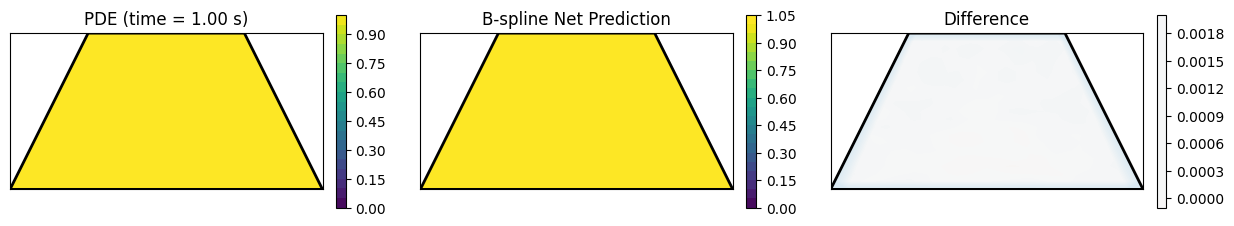

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

# Use the mapped PDE solution (PDE_map) for visualization on the trapezoid
nt_trap = PDE_map.shape[0]
t_vals_trap = t_trap  # Using the time values from your PDE solver

# Select 101 frames for a smooth animation
frames_trap = np.linspace(0, nt_trap - 1, 101, dtype=int)

# Define the vertices for the trapezoid and create a closed boundary
vertices = [(-1, 0), (1, 0), (0.5, 1.0), (-0.5, 1.0)]
trap_bdry = np.array(vertices + [vertices[0]])

# Create a figure with three subplots (all on the mapped grid)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Initial contour plots using the mapped versions (PDE_map and NET_map)
c0 = axs[0].contourf(Xc_tr, Yc_tr, PDE_map[0], levels=21, cmap='viridis', vmin=0, vmax=1)
c1 = axs[1].contourf(Xc_tr, Yc_tr, NET_map[0], levels=21, cmap='viridis', vmin=0, vmax=1)
c2 = axs[2].contourf(Xc_tr, Yc_tr, NET_map[0] - PDE_map[0], levels=21, cmap='RdBu', vmin=-0.2, vmax=0.2)

# Add colorbars to each subplot
fig.colorbar(c0, ax=axs[0], fraction=0.046, pad=0.04, shrink=0.5)
fig.colorbar(c1, ax=axs[1], fraction=0.046, pad=0.04, shrink=0.5)
fig.colorbar(c2, ax=axs[2], fraction=0.046, pad=0.04, shrink=0.5)

def update_anim_trap(frame_idx):
    """Update function for the animation."""
    k = frames_trap[frame_idx]  # Current frame index
    time_val = t_vals_trap[k]   # Corresponding time

    # Extract slices from the mapped solutions
    PDE_slice = PDE_map[k]
    NET_slice = NET_map[k]
    diff_slice = NET_slice - PDE_slice

    # Clear each subplot for fresh plotting
    for ax in axs:
        ax.clear()

    # Left subplot: Ground-truth PDE solution (mapped to trapezoid)
    axs[0].contourf(Xc_tr, Yc_tr, PDE_slice, levels=21, cmap='viridis', vmin=0, vmax=1)
    axs[0].plot(trap_bdry[:, 0], trap_bdry[:, 1], 'k-', lw=2)
    axs[0].set_title(f"PDE (time = {time_val:.2f} s)")

    # Middle subplot: B-spline net prediction (mapped to trapezoid)
    axs[1].contourf(Xc_tr, Yc_tr, NET_slice, levels=21, cmap='viridis', vmin=0, vmax=1)
    axs[1].plot(trap_bdry[:, 0], trap_bdry[:, 1], 'k-', lw=2)
    axs[1].set_title("B-spline Net Prediction")

    # Right subplot: Difference between prediction and PDE
    axs[2].contourf(Xc_tr, Yc_tr, diff_slice, levels=21, cmap='RdBu', vmin=-0.2, vmax=0.2)
    axs[2].plot(trap_bdry[:, 0], trap_bdry[:, 1], 'k-', lw=2)
    axs[2].set_title("Difference")

    # Set equal aspect ratio and remove axis ticks for all subplots
    for ax in axs:
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

    return []

# Create the animation
ani_trap = animation.FuncAnimation(fig, update_anim_trap, frames=len(frames_trap), interval=50, blit=False)

# Save the animation as an MP4 video if possible; otherwise, save as GIF
try:
    writer = animation.FFMpegWriter(fps=10, metadata=dict(artist='B-spline net visualization'), bitrate=1800)
    ani_trap.save("trap_view.mp4", writer=writer)
    print("Saved => trap_view.mp4")
except Exception as e:
    print("FFMPEG not available, saving as GIF instead. Error:", e)
    ani_trap.save("trap_view.gif", writer='pillow')

plt.show()


Prediction errors calculation

Calculating errors for 10 valid random α values (out of 15 trials):

Processing trial 1 with α = 1.156
α = 1.156: Valid trial | Avg MSE = 4.6828e-06, Avg MAE = 1.5574e-03, Avg L2 = 4.4180e-02, Avg rel L2 = 2.3273e-03

Processing trial 2 with α = 0.195
α = 0.195: Valid trial | Avg MSE = 2.0016e-04, Avg MAE = 8.2687e-03, Avg L2 = 2.8366e-01, Avg rel L2 = 1.7136e-02

Processing trial 3 with α = 0.238
α = 0.238: Valid trial | Avg MSE = 1.4729e-04, Avg MAE = 7.1151e-03, Avg L2 = 2.4324e-01, Avg rel L2 = 1.4530e-02

Processing trial 4 with α = 1.184
α = 1.184: Valid trial | Avg MSE = 4.7211e-06, Avg MAE = 1.5591e-03, Avg L2 = 4.4349e-02, Avg rel L2 = 2.3334e-03

Processing trial 5 with α = 1.339
α = 1.339: Valid trial | Avg MSE = 4.1223e-06, Avg MAE = 1.3411e-03, Avg L2 = 4.0658e-02, Avg rel L2 = 2.1372e-03

Processing trial 6 with α = 0.251
α = 0.251: Valid trial | Avg MSE = 1.1992e-04, Avg MAE = 6.4350e-03, Avg L2 = 2.1938e-01, Avg rel L2 = 1.3063e-02

Processing trial 7 with α = 0.135
α =

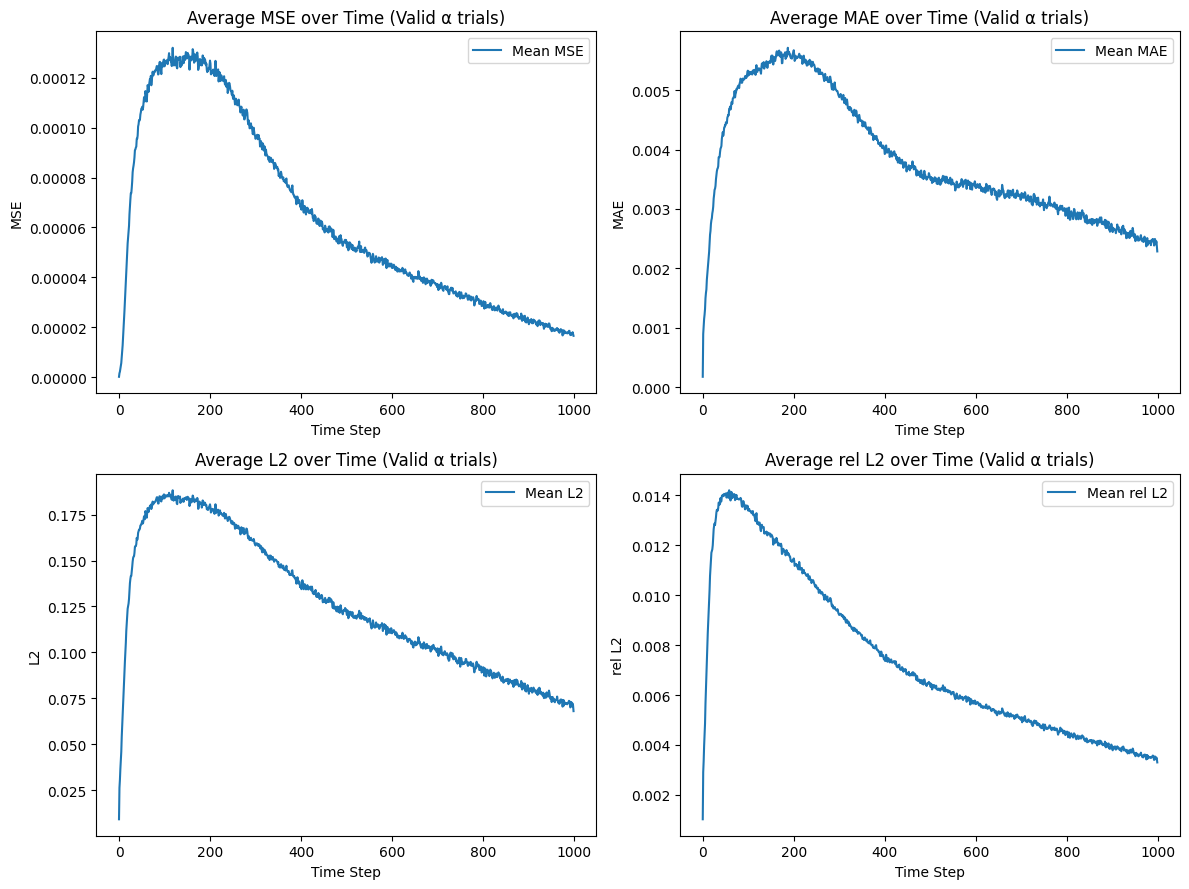

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# ====================================================
# 1. PDE Solver on the Trapezoid using a mapped grid
# ====================================================
def solve_pde_trapezoid_mapped_grid(Nx=21, Ny=21, T=1.0, dt=0.001, a=1.0):
    """
    Solve PDE: s_t = 0.5*( s_xx + a*s_yy ) on a trapezoid defined by the mapping:
         X = -1.0 + 0.5*y + x*(2.0-y)
         Y = y
    with boundary s=1 and interior s=0 at t=0.
    """
    # Create a regular square grid in parameter space
    x_sq = np.linspace(0, 1, Nx)
    y_sq = np.linspace(0, 1, Ny)
    X_sq, Y_sq = np.meshgrid(x_sq, y_sq, indexing='xy')

    # Map to physical trapezoid
    X = -1.0 + 0.5 * Y_sq + X_sq * (2.0 - Y_sq)
    Y = Y_sq.copy()

    # Compute variable spacing in x for each row
    dx_arr = (2.0 - y_sq) / (Nx - 1)
    dy = 1.0 / (Ny - 1)

    # Initial condition: interior 0, boundary = 1
    s = np.zeros((Ny, Nx), dtype=np.float32)
    s[0, :], s[-1, :], s[:, 0], s[:, -1] = 1.0, 1.0, 1.0, 1.0

    n_steps = int(T / dt) + 1
    t_vals = np.linspace(0, T, n_steps, dtype=np.float32)
    S_all = np.zeros((n_steps, Ny, Nx), dtype=np.float32)
    S_all[0] = s.copy()

    # Time-stepping loop (explicit Euler)
    for step in range(1, n_steps):
        s_old = s.copy()
        for j in range(1, Ny - 1):
            dx = dx_arr[j]
            for i in range(1, Nx - 1):
                s_xx = (s_old[j, i + 1] - 2 * s_old[j, i] + s_old[j, i - 1]) / (dx * dx)
                s_yy = (s_old[j + 1, i] - 2 * s_old[j, i] + s_old[j - 1, i]) / (dy * dy)
                dsdt = 0.5 * (s_xx + a * s_yy)
                s[j, i] = s_old[j, i] + dt * dsdt

        # Re-enforce Dirichlet boundary = 1
        s[0, :], s[-1, :], s[:, 0], s[:, -1] = 1.0, 1.0, 1.0, 1.0
        S_all[step] = s.copy()

    return X, Y, t_vals, S_all


# ====================================================
# 2. Helper function: compute inside mask for trapezoid grid
# ====================================================
def compute_inside_mask(X, Y, vertices):
    poly = Polygon(vertices)
    ny, nx = X.shape
    mask = np.zeros((ny, nx), dtype=bool)
    for j in range(ny):
        for i in range(nx):
            mask[j, i] = poly.covers(Point(X[j, i], Y[j, i]))
    return mask


# ====================================================
# 3. Wrapper for trapezoid solver that returns 5 outputs
# ====================================================
def solve_pde_trapezoid_a(vertices, dx, T, dt, a):
    """
    Wrapper for the trapezoid PDE solver that returns:
      X, Y, t_vals, S_all, inside_mask
    """
    # Use the same grid resolution as in training (Nx = 21, Ny = 21)
    Nx = 21
    Ny = 21
    X, Y, t_vals, S_all = solve_pde_trapezoid_mapped_grid(Nx=Nx, Ny=Ny, T=T, dt=dt, a=a)
    inside_mask = compute_inside_mask(X, Y, vertices)
    return X, Y, t_vals, S_all, inside_mask


# ====================================================
# 4. New mapping function to map square solutions to the trapezoid
# using the same grid as the trapezoid solver.
# ====================================================
def map_square_to_trapezoid_same(S_sqr, Nx_sqr, Ny_sqr):
    """
    Map a solution defined on the square [0,1]^2 (shape: (nt, Ny_sqr, Nx_sqr))
    to the physical trapezoid using the same mapping as the trapezoid solver.
    Returns: S_sqr (unchanged), X_phys, Y_phys, and a mask (all True).
    """
    # Create uniform square grid on [0,1]
    x_sq = np.linspace(0, 1, Nx_sqr)
    y_sq = np.linspace(0, 1, Ny_sqr)
    X_sq, Y_sq = np.meshgrid(x_sq, y_sq, indexing='xy')

    # Map to physical trapezoid
    X_phys = -1.0 + 0.5 * Y_sq + X_sq * (2.0 - Y_sq)
    Y_phys = Y_sq.copy()

    mask = np.ones((Ny_sqr, Nx_sqr), dtype=bool)
    return S_sqr, X_phys, Y_phys, mask


# ====================================================
# 5. Error metrics function (MSE, MAE, L2, rel L2)
# ====================================================
def compute_error_metrics(sol_pred, sol_ref, mask, eps=1e-12):
    """
    sol_pred, sol_ref: arrays of shape (nt, ny, nx)
    mask: boolean array of shape (ny, nx) specifying valid points.

    Returns per-time-step arrays:
      mse, mae, l2, rel_l2
    where:
      l2[k]      = ||pred-ref||_2 over masked points
      rel_l2[k]  = ||pred-ref||_2 / (||ref||_2 + eps)
    """
    nt = sol_pred.shape[0]
    mse = np.zeros(nt, dtype=np.float64)
    mae = np.zeros(nt, dtype=np.float64)
    l2 = np.zeros(nt, dtype=np.float64)
    rel_l2 = np.zeros(nt, dtype=np.float64)

    for k in range(nt):
        diff = sol_pred[k] - sol_ref[k]
        d = diff[mask].astype(np.float64)
        r = sol_ref[k][mask].astype(np.float64)

        mse[k] = np.mean(d ** 2)
        mae[k] = np.mean(np.abs(d))

        l2_k = np.sqrt(np.sum(d ** 2))
        ref_l2_k = np.sqrt(np.sum(r ** 2))

        l2[k] = l2_k
        rel_l2[k] = l2_k / (ref_l2_k + eps)

    return mse, mae, l2, rel_l2


# ====================================================
# 6. Settings and Testing Loop
# ====================================================

# Settings (must match those used previously)
Nx = 21
Ny = 21
T = 1.0

dt_trap = 0.001  # Use this time step for both PDE solvers and mapping.
dx_trap = 0.05   # (Not used in new mapping function)

vertices = [(-1, 0), (1, 0), (0.5, 1.0), (-0.5, 1.0)]

print("Calculating errors for 10 valid random α values (out of 15 trials):")
n_valid_required = 10
n_trials = 15
trial_count = 0

valid_alphas = []
valid_mse_trials = []
valid_mae_trials = []
valid_l2_trials = []
valid_rell2_trials = []

while trial_count < n_trials and len(valid_alphas) < n_valid_required:
    a_val = np.random.uniform(0, 1.5)
    print(f"\nProcessing trial {trial_count + 1} with α = {a_val:.3f}")

    try:
        # ------------------------------------------------------------
        # 1) Solve the PDE on the square (USER PROVIDED FUNCTION)
        #    Must exist in your environment:
        #      solve_pde_2d_a(Nx, Ny, T, a, dt) -> x_sqr, y_sqr, t_sqr, PDE_sqr
        # ------------------------------------------------------------
        x_sqr, y_sqr, t_sqr, PDE_sqr = solve_pde_2d_a(Nx=Nx, Ny=Ny, T=T, a=a_val, dt=dt_trap)

        # ------------------------------------------------------------
        # 2) Get the B-spline net prediction on the square (USER PROVIDED)
        #    Must exist in your environment:
        #      device, net, Bit_t, Bit_x, Bit_y, Bit_t_deriv, Bit_x_second, Bit_y_second
        #      compute_loss_pde_data_icbc(...)
        # ------------------------------------------------------------
        with torch.no_grad():
            a_tensor = torch.tensor([[a_val]], dtype=torch.float32, device=device)
            _, _, _, net_sqr, _ = compute_loss_pde_data_icbc(
                net,
                a_tensor,
                torch.tensor(PDE_sqr, device=device),
                Bit_t, Bit_x, Bit_y,
                Bit_t_deriv, Bit_x_second, Bit_y_second,
                lambda_data=0.0, lambda_phys=0.0
            )
        net_sqr_np = net_sqr[0].cpu().numpy()  # shape: (nt, Ny, Nx)

        # ------------------------------------------------------------
        # 3) Map square solutions to trapezoid grid (same resolution)
        # ------------------------------------------------------------
        PDE_map, Xc, Yc, mask = map_square_to_trapezoid_same(PDE_sqr, Nx, Ny)
        NET_map, _, _, _ = map_square_to_trapezoid_same(net_sqr_np, Nx, Ny)

        # ------------------------------------------------------------
        # 4) Solve PDE directly on trapezoid
        # ------------------------------------------------------------
        X_trap, Y_trap, t_trap, PDE_trap, inside_mask = solve_pde_trapezoid_a(
            vertices, dx=dx_trap, T=T, dt=dt_trap, a=a_val
        )

        # ------------------------------------------------------------
        # 5) Align time steps
        # ------------------------------------------------------------
        nt_common = min(NET_map.shape[0], PDE_trap.shape[0])
        NET_map_aligned = NET_map[:nt_common]
        PDE_trap_aligned = PDE_trap[:nt_common]

        # ------------------------------------------------------------
        # 6) Compute error metrics (MSE, MAE, L2, rel L2)
        # ------------------------------------------------------------
        mse, mae, l2, rel_l2 = compute_error_metrics(
            NET_map_aligned, PDE_trap_aligned, mask
        )

        avg_mse = float(np.mean(mse))
        avg_mae = float(np.mean(mae))
        avg_l2 = float(np.mean(l2))
        avg_rell2 = float(np.mean(rel_l2))

        if (
            np.all(np.isfinite(mse)) and np.all(np.isfinite(mae)) and
            np.all(np.isfinite(l2)) and np.all(np.isfinite(rel_l2)) and
            avg_mse < 1e5 and avg_mae < 1e5 and avg_l2 < 1e8 and avg_rell2 < 1e5
        ):
            valid_alphas.append(a_val)
            valid_mse_trials.append(mse)
            valid_mae_trials.append(mae)
            valid_l2_trials.append(l2)
            valid_rell2_trials.append(rel_l2)

            print(
                f"α = {a_val:.3f}: Valid trial | "
                f"Avg MSE = {avg_mse:.4e}, Avg MAE = {avg_mae:.4e}, "
                f"Avg L2 = {avg_l2:.4e}, Avg rel L2 = {avg_rell2:.4e}"
            )
        else:
            print(
                f"α = {a_val:.3f}: Trial skipped | "
                f"Avg MSE={avg_mse:.4e}, Avg MAE={avg_mae:.4e}, "
                f"Avg L2={avg_l2:.4e}, Avg rel L2={avg_rell2:.4e}"
            )

    except Exception as e:
        print(f"α = {a_val:.3f}: Exception encountered: {e}. Skipping trial.")

    trial_count += 1

if len(valid_alphas) < n_valid_required:
    print(f"\nOnly {len(valid_alphas)} valid trials found. Please try running again.")
else:
    # truncate to required
    valid_alphas = valid_alphas[:n_valid_required]
    valid_mse_trials = valid_mse_trials[:n_valid_required]
    valid_mae_trials = valid_mae_trials[:n_valid_required]
    valid_l2_trials = valid_l2_trials[:n_valid_required]
    valid_rell2_trials = valid_rell2_trials[:n_valid_required]

    nt_common = min(trial.shape[0] for trial in valid_mse_trials)

    mse_array = np.array([trial[:nt_common] for trial in valid_mse_trials], dtype=np.float64)
    mae_array = np.array([trial[:nt_common] for trial in valid_mae_trials], dtype=np.float64)
    l2_array = np.array([trial[:nt_common] for trial in valid_l2_trials], dtype=np.float64)
    rell2_array = np.array([trial[:nt_common] for trial in valid_rell2_trials], dtype=np.float64)

    mean_mse_over_time = np.mean(mse_array, axis=0)
    std_mse_over_time  = np.std(mse_array, axis=0)

    mean_mae_over_time = np.mean(mae_array, axis=0)
    std_mae_over_time  = np.std(mae_array, axis=0)

    mean_l2_over_time  = np.mean(l2_array, axis=0)
    std_l2_over_time   = np.std(l2_array, axis=0)

    mean_rell2_over_time = np.mean(rell2_array, axis=0)
    std_rell2_over_time  = np.std(rell2_array, axis=0)

    overall_avg_mse  = float(np.mean(mse_array))
    overall_std_mse  = float(np.std(mse_array))

    overall_avg_mae  = float(np.mean(mae_array))
    overall_std_mae  = float(np.std(mae_array))

    overall_avg_l2   = float(np.mean(l2_array))
    overall_std_l2   = float(np.std(l2_array))

    overall_avg_rell2 = float(np.mean(rell2_array))
    overall_std_rell2 = float(np.std(rell2_array))


    print("\nFinal average errors over valid trials (mean ± std):")
    print(f"MSE     = {overall_avg_mse:.4e} ± {overall_std_mse:.4e}")
    print(f"MAE     = {overall_avg_mae:.4e} ± {overall_std_mae:.4e}")
    print(f"L2      = {overall_avg_l2:.4e} ± {overall_std_l2:.4e}")
    print(f"rel L2  = {overall_avg_rell2:.4e} ± {overall_std_rell2:.4e}")


    # Plot average error curves over time (2x2)
    plt.figure(figsize=(12, 9))

    plt.subplot(2, 2, 1)
    plt.plot(mean_mse_over_time[:-1], label='Mean MSE')
    plt.xlabel('Time Step')
    plt.ylabel('MSE')
    plt.title('Average MSE over Time (Valid α trials)')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(mean_mae_over_time[:-1], label='Mean MAE')
    plt.xlabel('Time Step')
    plt.ylabel('MAE')
    plt.title('Average MAE over Time (Valid α trials)')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(mean_l2_over_time[:-1], label='Mean L2')
    plt.xlabel('Time Step')
    plt.ylabel('L2')
    plt.title('Average L2 over Time (Valid α trials)')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(mean_rell2_over_time[:-1], label='Mean rel L2')
    plt.xlabel('Time Step')
    plt.ylabel('rel L2')
    plt.title('Average rel L2 over Time (Valid α trials)')
    plt.legend()

    plt.tight_layout()
    plt.show()
